<a href="https://colab.research.google.com/github/stefaniemeliss/IADS_SC_2022_Optimisation_ML/blob/main/k_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exercise: k-means implementation in Python

This code was provided in the course, comments added.

Import libraries

In [ ]:
import random
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

from tkinter import *

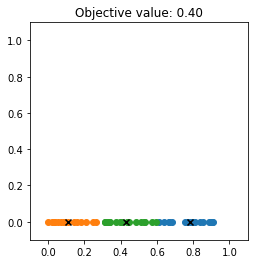

In [ ]:
# define class Instance
class Instance:
    def __init__(self, data, k):
        self.data = data
        self.k = k

# define class Solution
class Solution:
    def __init__(self, instance):
        self.instance = instance
        self.classes = [0] * len(instance.data)

    def update_classes(self, centroids):
        def lists_different(list1, list2):
            return len(list1) != len(list2) or any(list1[i] != list2[i] for i in range(len(list1)))

        def closest(point):
            x, y = point
            dist = [(x - cx) ** 2 + (y - cy) ** 2 for (cx, cy) in centroids]
            return np.argmin(dist)

        prev_classes = self.classes
        self.classes = [closest(d) for d in self.instance.data]
        return lists_different(self.classes, prev_classes)

    def calculate_centroids(self):
        def center_of_mass(points):
            if len(points) == 0:
                return 0.5, 0.5

            return sum([x for (x, _) in points]) / len(points), sum([y for (_, y) in points]) / len(points)

        return [center_of_mass([self.instance.data[j] for j in range(len(self.instance.data))
                                if self.classes[j] == i]) for i in range(self.instance.k)]

    def get_objective(self, centroids=None):
        if centroids is None:
            centroids = self.calculate_centroids()

        return sum((self.instance.data[i][0] - centroids[self.classes[i]][0]) ** 2
               + (self.instance.data[i][1] - centroids[self.classes[i]][1]) ** 2 for i in range(len(self.instance.data)))

# define function to construct a random centroid 
def construction_uniform_random(instance):
    solution = Solution(instance)
    centroids = [(random.random(), random.random()) for _ in range(instance.k)]
    solution.update_classes(centroids)
    return solution

# define function to perform random partitioning (i.e., assign each point to closest centroid)
def construction_random_partition(instance):
    solution = Solution(instance)
    solution.classes = [random.randint(0, instance.k - 1) for _ in range(len(instance.data))]
    return solution

# define function forgy
def construction_forgy(instance):
    solution = Solution(instance)
    centroids = random.choices(instance.data, k=instance.k)
    solution.update_classes(centroids)
    return solution

# define function k-means
def kmeans(instance, construction):
    solution = construction(instance)

    modified = True
    while modified:
        centroids = solution.calculate_centroids()
        modified = solution.update_classes(centroids)

    return solution, centroids

# define a function to plot the dataset
def plot_dataset(solution, axes):
    for i in range(solution.instance.k):
        points = [solution.instance.data[j] for j in range(len(solution.instance.data)) if solution.classes[j] == i]
        if len(points) > 0:
            axes.scatter(*zip(*points))

# define function to plot the centroids
def plot_centroids(centroids, axes):
    axes.scatter(*zip(*centroids), marker='x', c='black')


def plot(solution, centroids):
    plt.gca().set_aspect('equal', 'box')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plot_dataset(solution, plt.gca())
    plot_centroids(centroids, plt.gca())
    plt.title(f'Objective value: {solution.get_objective(centroids):.2f}')
    plt.show()


def multi_start(instance, construction, iterations):
    best_objective = sys.float_info.max
    best_solution = None
    for i in range(iterations):
        solution, centroids = kmeans(instance, construction)
        objective = solution.get_objective(centroids)
        if objective < best_objective:
            best_solution = solution
            best_objective = objective
        print(f'{objective:.2f}')

    return best_solution, best_solution.calculate_centroids()


def uniform_data(n):
    return [(random.random(), random.random()) for _ in range(n)]

# define function to generate data
def clustered_data(n, k):
    c = [(random.random() * 0.6 + 0.2, random.random() * 0.6 + 0.2) for _ in range(k)]
    return [(c[i][0] + random.random() * 0.2, c[i][1] + random.random() * 0.2) for i in random.choices(range(k), k=n)]


def uniform_data_1d(n):
    return [(random.random(), 0) for _ in range(n)]


def test_kmeans(instance, construction):
    solution, centroids = kmeans(instance, construction)
    plot(solution, centroids)


def test_multi_start(instance, construction, iterations):
    solution, centroids = multi_start(instance, construction, iterations)
    plot(solution, centroids)


running = True
iteration = 0
animation_centroids = []


class AnimationWindow:
    def __init__(self,  window, instance, construction):
        self.window = window

        self.playing = False
        self.iteration = 0
        self.finished = False
        self.scheduled_play = None

        panel = PanedWindow(window)
        self.button_next = Button(panel, text="Next", command=self.next)
        self.button_play = Button(panel, text="Play", command=self.play)
        self.button_next.pack(side=LEFT)
        self.button_play.pack(side=LEFT)
        self.slider = Scale(panel, from_=0, to=5, orient='horizontal', command=self.slider_moved, showvalue=0, label='Speed')
        self.slider.pack(side=LEFT)
        self.button_reset = Button(panel, text="Reset", command=self.reset)
        self.button_reset.pack(side=LEFT)
        panel.pack(side=TOP)

        self.instance = instance
        self.construction = construction
        self.solution = self.construction(self.instance)
        self.construction = construction
        self.animation_centroids = self.solution.calculate_centroids()
        self.fig = Figure()
        self.axes = self.fig.add_subplot()

        self.canvas = FigureCanvasTkAgg(self.fig, master=self.window)
        self.canvas.get_tk_widget().pack(fill=BOTH, side=TOP, expand=1)
        self.plot()

    def reset(self):
        self.window.after_cancel(self.scheduled_play)
        self.playing = False
        self.finished = False
        self.iteration = 0
        self.solution = self.construction(self.instance)
        self.animation_centroids = self.solution.calculate_centroids()

        self.button_next['state'] = NORMAL
        self.button_play['state'] = NORMAL

        self.plot()

    def slider_moved(self, _):
        self.window.after_cancel(self.scheduled_play)
        if self.playing:
            self.play()

    def next(self):
        if self.finished:
            return

        self.iteration += 1

        if self.iteration % 2 == 0:
            self.animation_centroids = self.solution.calculate_centroids()
        else:
            self.finished = not self.solution.update_classes(self.animation_centroids)
            if self.finished:
                self.button_next['state'] = DISABLED
                self.button_play['state'] = DISABLED

        self.plot()

    def play(self):
        self.playing = True
        self.next()
        if self.finished:
            self.playing = False
        else:
            self.scheduled_play = self.window.after(int(1000 / (2**self.slider.get())), self.play)

    def plot(self):
        self.axes.cla()
        self.axes.set_aspect('equal', 'box')
        self.axes.set_xlim([-0.1, 1.1])
        self.axes.set_ylim([-0.1, 1.1])

        self.axes.set_ylabel("Y", fontsize=14)
        self.axes.set_xlabel("X", fontsize=14)

        plot_dataset(self.solution, self.axes)
        plot_centroids(self.animation_centroids, self.axes)
        self.window.title(f'Objective value: {self.solution.get_objective(self.animation_centroids):.2f}; iteration {self.iteration}')
        self.canvas.draw()


def animate_kmeans(instance, construction):
    window = Tk()
    window.state('zoomed')
    AnimationWindow(window, instance, construction)
    window.mainloop()


def measure_average_quality(instance, construction, iterations):
    total = 0
    for i in range(iterations):
        solution, centroids = kmeans(instance, construction)
        total += solution.get_objective(centroids)

    print(f'Average objective value: {total / iterations:.2f}')


def local_search(solution):
    # This line calculates the objective value of the solution:
    cur_obj = solution.get_objective()

    # Implement a local search procedure here.  Suggested neighbourhood: for each element, try to change its class and
    # keep the new class if this change improved the solution.  Repeat the neighbourhood exploration until
    # the local search is 'stuck'.

    # The instance data is available via solution.instance.data and solution.instance.k.
    # The class of element i is accessible via solution.classes[i].

    return solution


def test_local_search(instance, construction):
    solution = construction(instance)
    solution = local_search(solution)
    plot(solution, solution.calculate_centroids())


def main():
    random.seed(123)

    # play around: use different ways to simulate data
    # data = clustered_data(30, 3)
    # data = uniform_data(1000)
    # data = uniform_data_1d(50)

    instance = Instance(data, 3)

    # random.seed()

    # play around: train different construction methods
    # test_kmeans(instance, construction_uniform_random)
    test_kmeans(instance, construction_random_partition)
    test_kmeans(instance, construction_forgy)

    # animate the iterative process: only works locally in Python, not in colab
    # animate_kmeans(instance, construction_uniform_random)

    # test_multi_start(instance, construction_uniform_random, 10)

    # measure_average_quality(instance, construction_random_partition, 100)
    # measure_average_quality(instance, construction_uniform_random, 100)
    # measure_average_quality(instance, construction_forgy, 100)

    # test_local_search(instance, construction_uniform_random)


main()

# K-means in scikit learn

This part is heavily based on this source: https://stackabuse.com/k-means-clustering-with-scikit-learn/

In [ ]:
# import pandas
import pandas as pd

# Import scikit learn
from sklearn import datasets
from sklearn.cluster import KMeans

# Import libraries for plotting
import seaborn as sns
import matplotlib.pyplot as plt

### Import data

In [ ]:
# Load data
wine = datasets.load_wine()
# Print description of data to confirm data is loaded
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

In [ ]:
# load data into pandas
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


### Data exploration

In [ ]:
df.describe().T # T is for transposing the table

,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


In [ ]:
df.info()
# no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

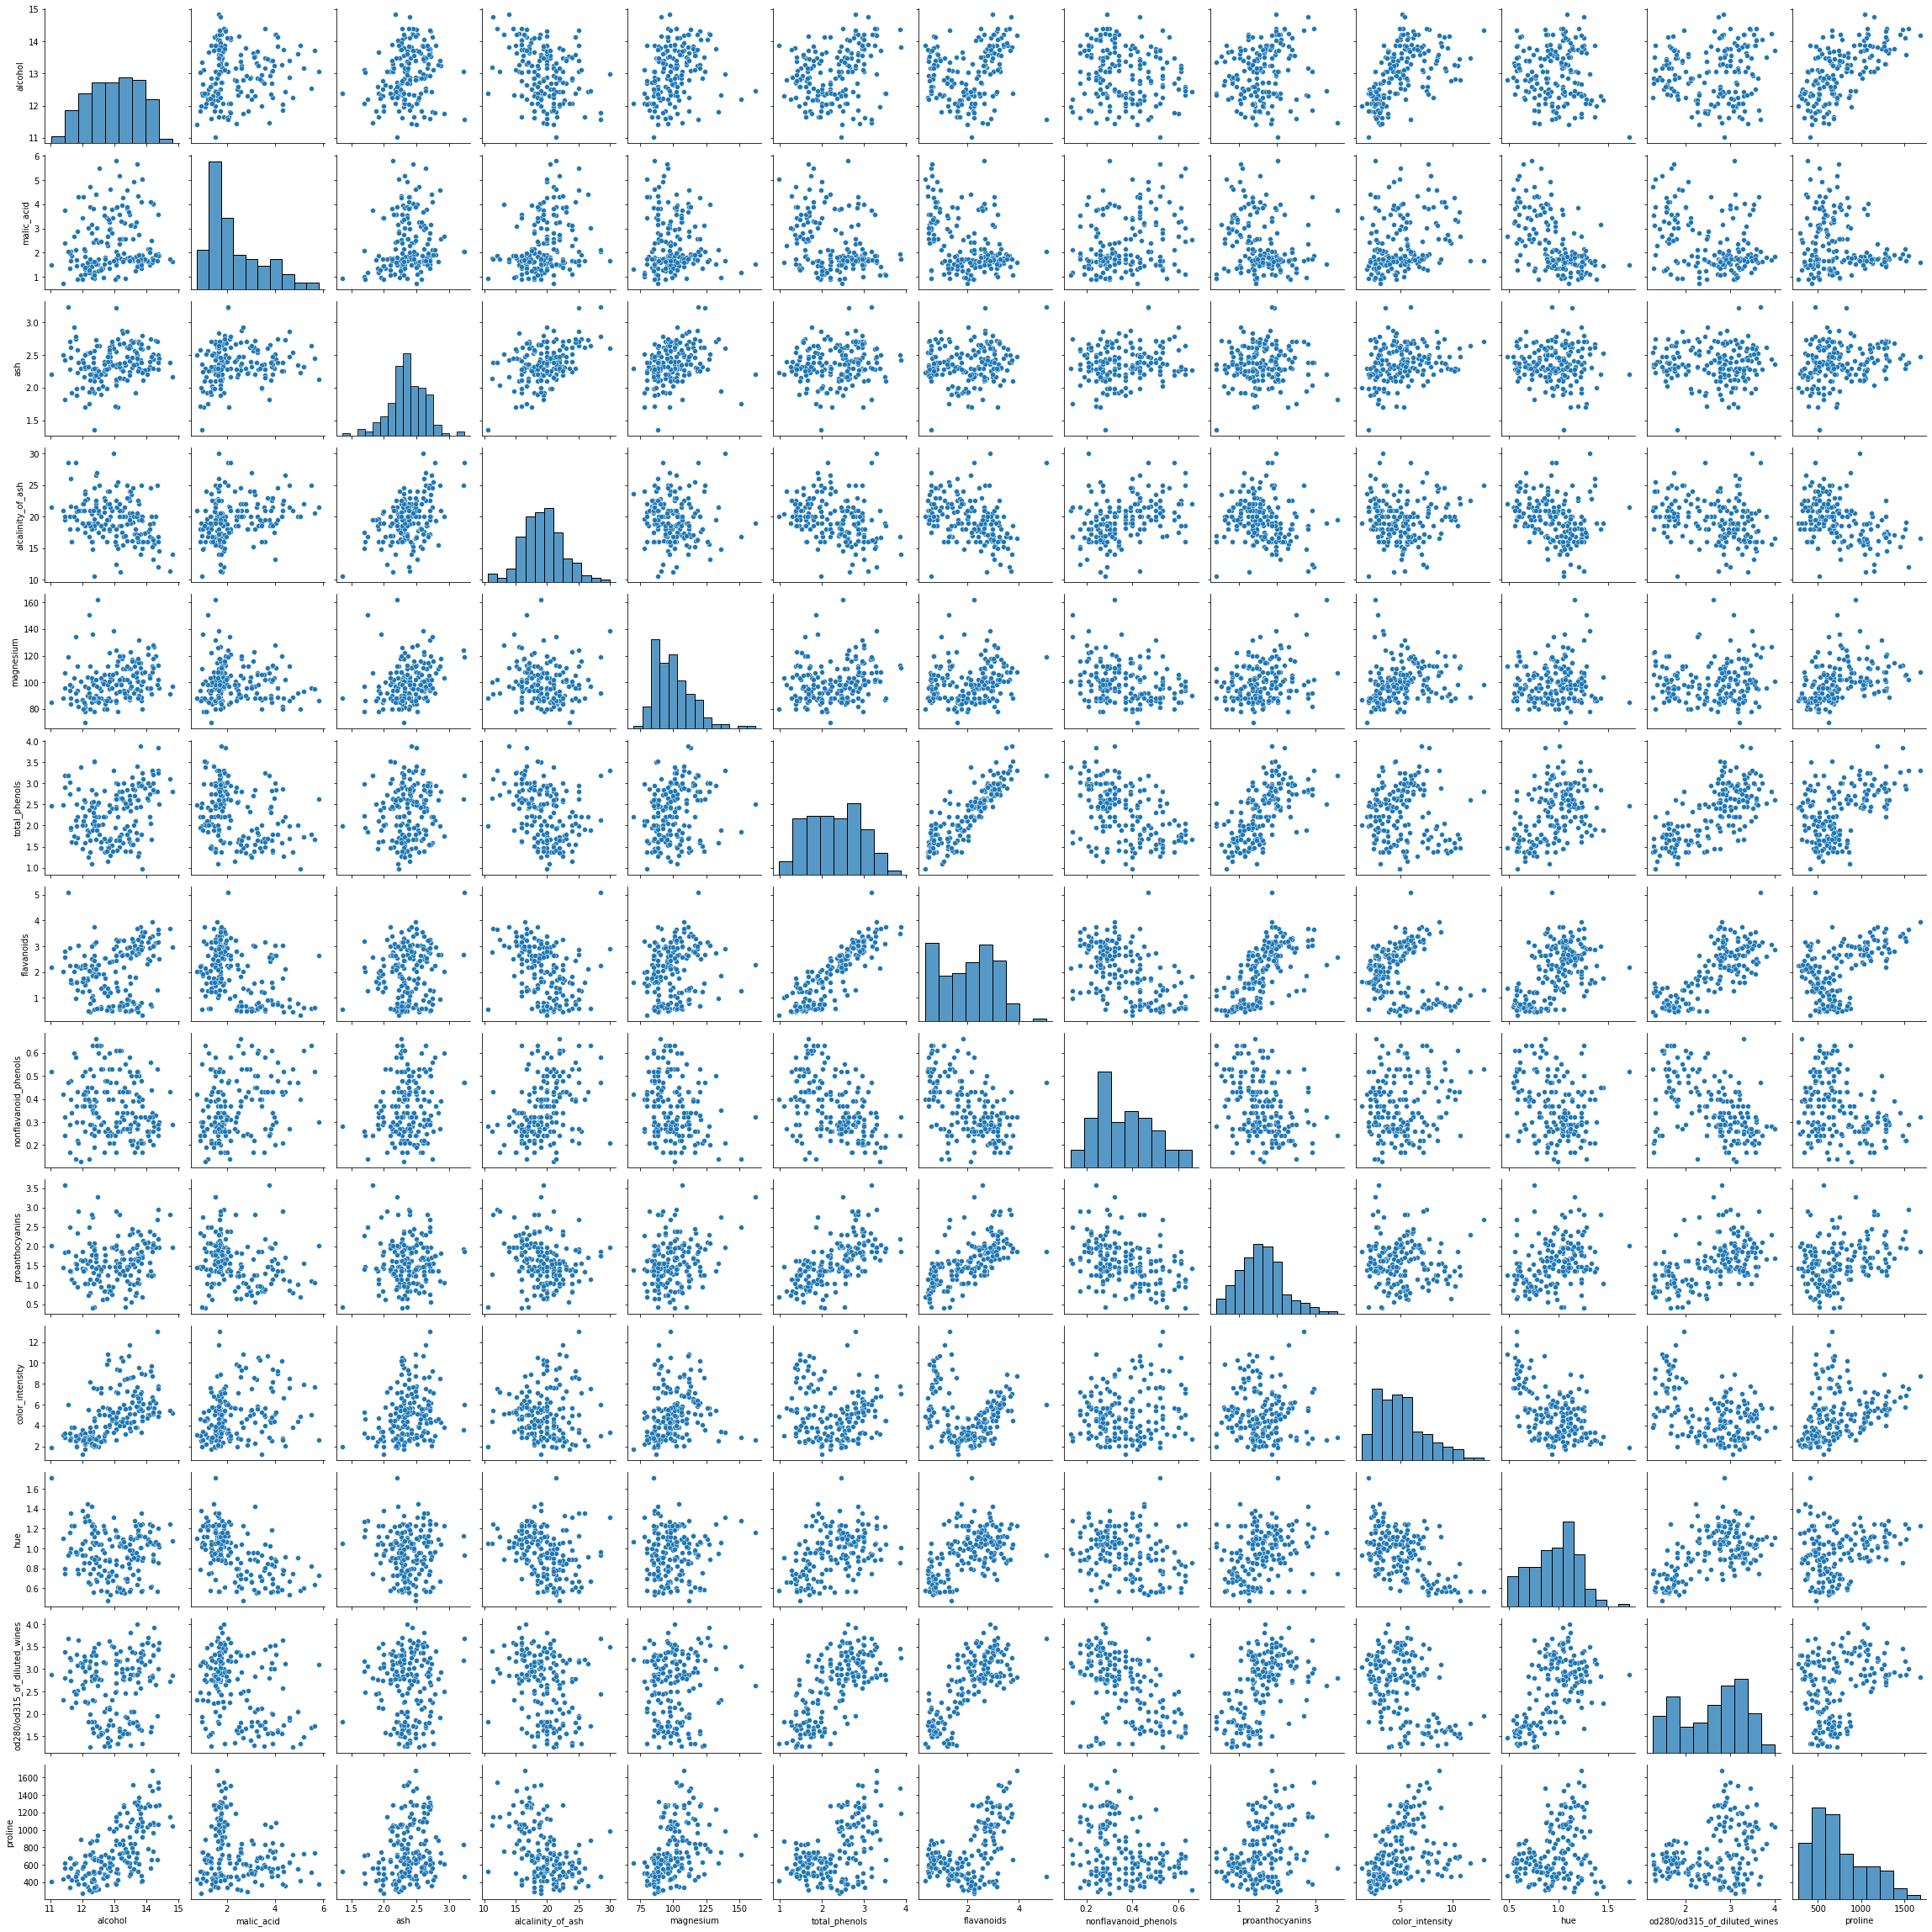

In [ ]:
sns.pairplot(df)

# By looking at the pairplot, two columns seem promising for clustering purposes:
# alcohol and od280 (which is a method for determining the protein concentration in wines). 
# It seems that there are 3 distinct clusters on plots combining two of them.

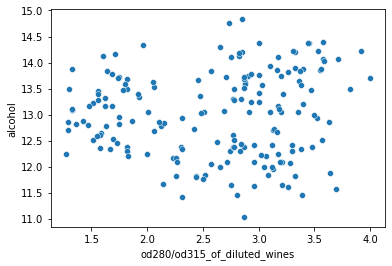

In [ ]:
sns.scatterplot(data=df, x="od280/od315_of_diluted_wines", y="alcohol")

### Elbow method

By plotting the Ks along with the Within Cluster Sum of Squares (WCSS), we are using the Elbow Method to choose the number of Ks. And the chosen K is exactly the lowest elbow point.

WCSS measures variance within a cluster by calculating the sum of squared difference between a given point and its centroid.

In [ ]:
# Now we can define our columns and use the elbow method to determine the number of clusters. 
# We will also initiate the algorithm with kmeans++ just to make sure it converges more quickly:

values = df[['od280/od315_of_diluted_wines', 'alcohol']]

wcss_wine = [] # Within Cluster Sum of Squares (WCSS)
for i in range(1, 11): # determine number of clusters to start with
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(values) 
    wcss_wine.append(kmeans.inertia_)

[205.87732640449445,
 118.94789143870317,
 58.32594553894381,
 46.7625956980057,
 36.51671187132064,
 30.41709384150064,
 26.581135229323316,
 23.12498052503053,
 20.350874641751957,
 18.459833846223916]

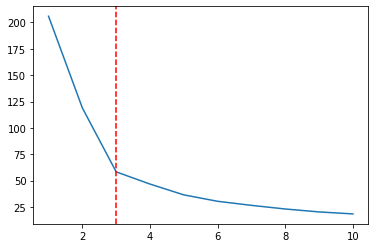

In [ ]:
clusters_wine = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.plot(clusters_wine, wcss_wine)
plt.axvline(3, linestyle='--', color='r')

# According to the elbow method we should have 3 clusters here

### Run k-means with k=3

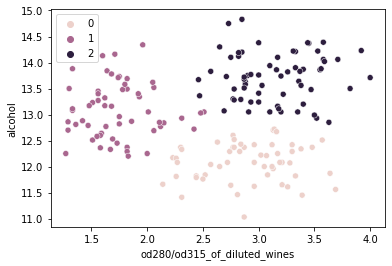

In [ ]:
kmeans_wine = KMeans(n_clusters=3, random_state=42)
kmeans_wine.fit(values)
sns.scatterplot(x = values['od280/od315_of_diluted_wines'], y = values['alcohol'], hue=kmeans_wine.labels_)

Based on our analysis, group 0 has wines with higher protein content and lower alcohol, group 1 has wines with higher alcohol content and low protein, and group 2 has both high protein and high alcohol in its wines.

### K-Means Optimisation & Parameters

sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')

<ul>
  <li>n_clusters: The number of clusters to form as well as the number of centroids to generate.</li>
  <li>init: Method for initialization:</li>
  <ul>
    <li>‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.</li>
    <li>‘random’: choose n_clusters observations (rows) at random from data for the initial centroids.</li>
    <li>If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.</li>
    <li>If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.</li>
  </ul>
  <li>n_init: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.</li>
  <li>max_iter: Maximum number of iterations of the k-means algorithm for a single run.</li>
  <li>tol: Relative tolerance with regards to Frobenius norm of the difference in the cluster centers of two consecutive iterations to declare convergence.</li>
  <li>random_state: Determines random number generation for centroid initialization. Use an int to make the randomness deterministic.</li>
  <li>copy_x: When pre-computing distances it is more numerically accurate to center the data first. If copy_x is True (default), then the original data is not modified. If False, the original data is modified, and put back before the function returns, but small numerical differences may be introduced by subtracting and then adding the data mean. Note that if the original data is not C-contiguous, a copy will be made even if copy_x is False. If the original data is sparse, but not in CSR format, a copy will be made even if copy_x is False.</li>
  <li>algorithm: K-means algorithm to use. The classical EM-style algorithm is "lloyd". The "elkan" variation can be more efficient on some datasets with well-defined clusters, by using the triangle inequality. However it’s more memory intensive due to the allocation of an extra array of shape (n_samples, n_clusters). "auto" and "full" are deprecated and they will be removed in Scikit-Learn 1.3. They are both aliases for "lloyd".</li>
</ul>








